# Code gists for ECML21 submission 394

### OBELISC: Oscillator-Based Modelling and Control using Efficient Neural Learning for Road Traffic Signal Offset Calculation

## Basics

- The dynamics of a **traffic signal is periodic**, with a phase of green, yellow and red light in one cycle. 

- Periodic dynamics of a signal is given by **3 control parameters**: **a cycle length**, **an offset** and **a split**. 

- An **offset** is a **phase difference between adjacent signals**, and a split is a ratio of a green light time. 

## Modelling

- A **coupled system of oscillators** can be used to **control flow** in a **road traffic network**. 

- The **global flow control** is realized by a **local interaction** between **traffic lights**, each of which is modeled by an **oscillator** located on a network cross **traffic light**. 

- The **oscillators interact** with the adjacent ones to **adjust the timing of the green traffic light**. A coupling strength is given by a **traffic flow density**.

- Such a system can benefit from the **pair-wise local interaction** between the adjacent oscillators that leads to an **entrainment** with a **phase difference** which corresponds to a **signal offset**.

## Mapping to the traffic system

- An intersection $C_i$ has signal $i$ corresponding to a traffic light at that intersection and described by an **oscillator**.

### Single oscillator

- A phase $\phi_i(t)$ of signal $i$ at time $t$ is given by a constant phase velocity motion with period $T$. Namely, the dynamics of signal $i$ is given by the following equation for a phase with frequency $ω = \frac{2π} {T}$ is:

$${d\phi_i\over {\rm dt}}=\omega$$

- Considering $\phi_i=0$ as the phase at a start time of a green light for a certain direction at intersection $C_i$ then the offset as a delay of signal $i$ from $j$ is given by $\phi_j−\phi_i$.


## Mapping to the traffic system

- An intersection $C_i$ has signal $i$ corresponding to a traffic light at that intersection, and is described by an **oscillator**.

### Pair of interacting oscillators

For a coupled system with 2 oscillators we define the **interaction as the phase difference at each time $t$**

$$
\eqalignno{ &\left\{\matrix{ {d\phi_1\over dt}\ =\omega_{1}+\Gamma(\phi_{2}-\phi_{1}-\Delta_{21})\cr {d\phi_2\over dt}\ =\omega_{2}+\Gamma(\phi_{1}-\phi_{2}-\Delta_{12}) }\right. \cr &\Gamma(\phi)=K\cdot\sin(\phi) \cr &{(K: {\rm a} \ {\rm coupling} \ {\rm coefficient)}}}
$$

For a coupled system with n oscillators we define the **interaction as the phase difference at each time $t$**

$$
\eqalignno{ &\left\{\matrix{ {d\phi_1\over dt}\ =\omega_{1}+\Gamma(\phi_{2}-\phi_{1}-\Delta_{21}) + f(green_{time})+ g(cycle_{lenght}) + h(travel_{time}) + l(flow) \cr {d\phi_2\over dt}\ =\omega_{2}+\Gamma(\phi_{1}-\phi_{2}-\Delta_{12}) + f(green_{time})+ g(cycle_{lenght}) + l(flow) \cr
...\cr
{d\phi_n\over dt}\ =\omega_{n}+\Gamma(\phi_{1}-\phi_{2} - ... -\Delta_{12} -... \Delta_{(n-1)n})  + f(green_{time})+ g(cycle_{lenght}) + h(travel_{time}) + l(flow) }\right. \cr 
&\Gamma(\phi)=K\cdot\sin(\phi) \cr &{(K: {\rm a} \ {\rm coupling} \ {\rm coefficient} \ {\rm from} \ {\rm  spatial} \ {\rm topology)}}}
$$


# Experiment with coupled oscillators

In [1]:
# Coupled oscillators analysis - Plotting utils
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib notebook

# Plot the network used for the current simulation
def plot_graph(graph, ax):
    # generate some node properties
    labels = {}
    for n in graph.nodes():
        labels[n] = n

    # compute layout
    pos = nx.nx_pydot.graphviz_layout(graph, prog='neato')

    # draw graph
    nx.draw(
        graph, pos,
        node_color='lightskyblue', node_size=400,
        font_size=40, 
        ax=ax)
    nx.draw_networkx_labels(graph, pos, labels)

# Plot the correlation values between each of the nodes, over time    
def plot_corr_vals(corr_vals, t, ax):
	for i in range(np.size(corr_vals, 0)):
		ax.plot(t, corr_vals[i, :])
	ax.set_xlabel('t', fontsize = 15)
	ax.set_ylabel('Correlation values', fontsize = 15)

# Plot the time evolution of the system    
def plot_time_evolution(sol, t, Omea, ax):
	Phi = lambda t: Omega*t
	nf = np.size(sol, 0)
	for i in range(nf):
		ax.plot(t, sol[i, :], label = "f %d" % (i))
	ax.plot(t, (Phi(t) % (2*np.pi)), linewidth=2, color='r', label = "driver")
	ax.legend(loc = 'upper right', prop = {'size':10})
	ax.set_xlabel("t", fontsize = 15)
	ax.set_ylabel(r"$\theta$", fontsize = 15)

# Plot system evolution as a heat map    
def plot_heatmap_evolutions(sol, t, ax):
    ax.imshow(
        sol, aspect='auto',
        cmap=plt.cm.gray, interpolation='nearest', 
        extent = (0, t[-1], 0, np.size(sol, 0)))

    ax.set_xlabel(r'$t$', fontsize = 15)
    ax.set_ylabel(r'$\Theta_i$', fontsize = 15)

# Plot the averaged sum of the correlation matrices    
def plot_sum_corr_mat(sum_rho_avg, ax):
	im = ax.imshow(sum_rho_avg, 
		cmap = plt.cm.coolwarm, 
		interpolation='nearest')
	divider = make_axes_locatable(ax)
	cax = divider.append_axes('right', size='15%', pad=0.2)
	cbar = plt.colorbar(im, cax=cax)
	cbar.ax.tick_params(labelsize=15) 
	ax.set_title('Correlation matrix', fontsize=15)

# Plot the matrix stroring the time to correlation for one run
def plot_time_to_sync(D_average, ax):
	im = plt.imshow(D_average, 
		cmap = plt.cm.coolwarm, 
		interpolation='nearest')
	divider = make_axes_locatable(ax)
	cax = divider.append_axes('right', size='15%', pad=0.2)
	cbar = plt.colorbar(im, cax=cax)
	cbar.ax.tick_params(labelsize=15) 
	ax.set_title('Time to synchronization in dynamic correlation matrix', fontsize = 15)

# Plot the sum of the correlation matrices, averaged over a number of runs    
def plot_corr_mat_dcm(G, sum_rho_avg, D_average):
	plt.figure()
	gs = mpl.gridspec.GridSpec(1, 3)
	plot_graph(G, plt.subplot(gs[:, 0]))
	plot_sum_corr_mat(sum_rho_avg, plt.subplot(gs[:, 1]))
	plot_time_to_sync(D_average, plt.subplot(gs[:, 2]))

# Plot the time evolution (as time series and as heat-map), 
# together with the corresponding correlation values between each of the nodes    
def plot_time_corr(G, sol, corr_vals, Omega, t):
	plt.figure()
	gs = mpl.gridspec.GridSpec(2, 2)
	plot_graph(G, plt.subplot(gs[0, 0]))
	plot_time_evolution(sol, t, Omega, plt.subplot(gs[0, 1]))
	plot_corr_vals(corr_vals, t, plt.subplot(gs[1, 1]))
	plot_heatmap_evolutions(sol, t, plt.subplot(gs[1, 0]))
	plt.savefig('images/time_corr.png')

In [2]:
# Core dynamics of the oscillator system
import numpy as np
import matplotlib as mpl
from scipy.integrate import odeint
import networkx as nx
import time
from tqdm import trange

# Generate the system of ODEs for the coupled oscillators
def system_generator(w, A, B, Phi, nf):

	def f(theta, t = 0):
		state = np.zeros(nf)
		for i in range(nf):
			for j in range(nf):
				state[i] += A[i, j]*np.sin(theta[j] - theta[i])
			state[i] += w[i] + B[i] * np.sin(Phi(t) - theta[i])
		return state
	return f

# Solves the system of ODEs describing the oscillators, solution are the phases of the oscillators
def solve_system(t, w, A, B, Phi, correlations = False):
	nf = np.size(A, 0)
	f = system_generator(w, A, B, Phi, nf)
	init = np.random.uniform(0, 2*np.pi, nf) % (2*np.pi) # restricting the angles to the unit circle
	sol = (odeint(f, init, t).T) % (2*np.pi) #solve the system of ODEs

	if correlations == False:
		return sol
	else:
		corr_vals = np.zeros((nf*nf, np.size(sol, 1)))
		for i in range(np.size(sol, 1)):
			rho_t = correlation_matrix(sol[:, i]) # the correlation matrix at time t
			corr_vals[:, i] = rho_t.flatten()
		return sol, corr_vals

# Compute the corelation matrix at one point in time
def correlation_matrix(theta_t):
	n = np.size(theta_t)
	rho = np.zeros((n, n))
	for i in range(n):
		for j in range(n):
			rho[i][j] = np.cos(theta_t[i] - theta_t[j])
	return rho

# Compute the sum of the correlation matrices, averaged over the number of runs
def sum_correlation_matrices(t, w, A, B, Phi):
	nf = np.size(A, 0)
	f = system_generator(w, A, B, Phi, nf)
	rho_average = np.zeros((nf, nf))

	#initial values of the phases
	init = np.random.uniform(0, 2*np.pi, nf) % (2*np.pi) # restricting the angles to the unit circle
	sol = (odeint(f, init, t).T) % (2*np.pi) #solve the system of ODEs

	rho_sum = np.zeros((nf, nf)) # initialize the matrix which will hold the sum of the connectivity matrices
	D = np.zeros((nf, nf))
	T = 0.95 # synchronization threshold 
	for i in range(np.size(sol, 1)):
		rho_sum += correlation_matrix(sol[:, i])

	rho_average += rho_sum
	return rho_average

# Compute the time to synchronization of each two nodes in the network
def time_to_sync_matrix(t, w, A, B, Phi):
	# time to value-switch from 0 to some nonzero number in the dynamic connectivity matrix, DCM
	nf = np.size(A, 0)
	f = system_generator(w, A, B, Phi, nf)
	D_average = np.zeros((nf, nf)) # initialize the DCM
	
	#initial values of the phases
	init = np.random.uniform(0, 2*np.pi, nf) % (2*np.pi) # restricting the angles to the unit circle
	sol = (odeint(f, init, t).T) % (2*np.pi) #solve the system of ODEs
	D = np.zeros((nf, nf)) # actual tyme-to-sync matrix
	T = 0.95 # synchronization threshold 
	for i in range(np.size(sol, 1)): # iterating through the time series
		rho_t = correlation_matrix(sol[:, i]) # the correlation matrix at time t
		idx = np.argwhere(rho_t > T)
		for j in idx:
	 		if D[tuple(j)] == 0:
	 			D[tuple(j)] = t[i]
	D_average += D
	return D

In [7]:
# Traffic network layout design
import numpy as np
import networkx as nx

# Generate a mesh network of given size
def load_mesh_network(size=2):
	G = nx.grid_graph(dim=[size,size])
	return G    

In [8]:
# Core analysis of the system dynamics
import numpy as np
from scipy.integrate import odeint
import networkx as nx
import time
from tqdm import*

# Compute the phase differences  of the oscillators to the driver
# This assumes that the oscillators have locked in frequency to the driver
def compute_phase_diffs(sol, t, Omega):
	Phi = lambda t: (Omega*t) 
	dt = t[-1] - t[-2]
	nf = np.size(sol, 0)
	phi = np.zeros(nf) # initializing vector of phase differences

	for i in range(nf):
		phi[i] = (Phi(t[-1]) % (2*np.pi)) - sol[i, -1]
		if phi[i] < 0:
			phi[i] += 2*np.pi
	return phi

# Recontruct the coupling coefficients
def reconstruct_coeffs(t, Omega_vec, omega, A, B):
	# basically recontruct the coupling coefficients strored in matrices A and B, 
	# using the phase differences between the oscillators and the driver
	# obtained for each Omega in Omega_vec.
	nf = np.size(A,0)
	b = np.repeat(Omega_vec, nf) - omega[1]

	#print("Solving a system of {} equations and {} unknowns.".format(len(Omega_vec)*nf, nf**2))

	M = np.zeros((len(Omega_vec)*nf, nf**2))
	for idx, Omega in enumerate(Omega_vec):
		Phi = lambda t: Omega*t
		sol = solve_system(t, omega, A, B, Phi)
		phi = compute_phase_diffs(sol, t, Omega)
		#print("phi = ", phi)
		for i in range(nf):
			row = np.array([])
			for j in range(nf):
				if i == j:
					continue
				row = np.append(row, np.sin(phi[i] - phi[j]))

			row = np.append(row, np.sin(phi[i]))
			M[idx*nf + i, i*nf : i*nf + nf] = row


	MM = np.array(M).T.dot(M)
	evals = np.linalg.eigvals(np.sqrt(np.array(MM).T.dot(MM)))
	cn = abs(max(evals) / min(evals))
	#print('Condition number:', cn, np.log10(cn))

	#print("M = ", M)
	x = np.linalg.lstsq(M, b)[0]

	x = np.reshape(x, (nf, nf))

	Brec = x[:, -1]

	Ahelp = x[:, 0:nf-1]
	Arec = np.zeros((nf, nf))
	for i in range(np.size(Ahelp, 0)):
		Arec[i, :] = np.insert(Ahelp[i, :], i, 0)

	#print("original A = \n", A)
	#print("reconstructed A = \n", Arec)
	#print("original B = \n", B)
	#print("reconstructed B = \n", Brec)

	return (Arec, Brec)

# Recontruct the coupling coefficients mask
def reconstruct_coeffs_mask(t, Omega_vec, omega, A, B):
	# basically recontruct the coupling coefficients strored in matrices A and B, 
	# using the phase differences between the oscillators and the driver
	# obtained for each Omega in Omega_vec.
    # compute the mask of the reconstruction
	nf = np.size(A,0)
	b = np.repeat(Omega_vec, nf*len(B)) - omega[1]

	#print("Solving a system of {} equations and {} unknowns.".format(len(Omega_vec)*nf*len(B), nf**2))

	M = np.zeros((len(Omega_vec)*nf*len(B), nf**2))
	idxM = 0
	for Omega in tqdm(Omega_vec):	
		Phi = lambda t: Omega*t
		for idx2, Bval in enumerate(B):
			Bmask = np.zeros((nf))
			Bmask[idx2] = Bval
			sol = solve_system(t, omega, A, Bmask, Phi)
			phi = compute_phase_diffs(sol, t, Omega)
			for i in range(nf):
				row = np.array([])
				for j in range(nf):
					if i == j:
						continue
					row = np.append(row, np.sin(phi[i] - phi[j]))
				if i == idx2:	
					row = np.append(row, np.sin(phi[i]))
				else:
					row = np.append(row, 0)
				M[idxM, i*nf : i*nf + nf] = row
				idxM += 1
				

	evals = np.linalg.eigvals(np.array(M).T.dot(M))
	cn = abs(max(evals) / min(evals))
	#print('Condition number:', cn, np.log10(cn))

	#print("M = ", M)
	x = np.linalg.lstsq(M, b)[0]

	x = np.reshape(x, (nf, nf))

	Brec = x[:, -1]

	Ahelp = x[:, 0:nf-1]
	Arec = np.zeros((nf, nf))
	for i in range(np.size(Ahelp, 0)):
		Arec[i, :] = np.insert(Ahelp[i, :], i, 0)

	#print("original A = \n", A)
	#print("reconstructed A = \n", Arec)
	#print("original B = \n", B)
	#print("reconstructed B = \n", Brec)

	return (Arec, Brec)

# Compute relative error of reconstruction
def compute_reconstruction_error(A, B, Arec, Brec):
    rel_err_A = abs(A - Arec) / (1 + abs(A))
    rel_err_B = abs(B - Brec) / (1 + abs(B))

    #print("Mean reconstruction error A: ", np.mean(rel_err_A.flatten()))
    #print("Mean reconstruction error B: ", np.mean(rel_err_B))

    return (rel_err_A, rel_err_B)

In [9]:
# Core simulation of the copupled oscillators system for traffic offset control
import numpy as np
import matplotlib as mpl
from scipy.integrate import odeint
import networkx as nx
import time
from tqdm import trange

# set simulation time
tmin = 0
tmax = 30
dt = 0.01 # time step
t = np.arange(tmin, tmax, dt) # the simulation time

In [11]:
# Load network of oscillators and parametrize the system
N = 2
G = load_mesh_network(N) # net
A = nx.adjacency_matrix(G).todense() # coupling matrix
nf = np.size(A, 0) # number orbits
w = 3*np.ones(nf) # frequency

# the parameters of the external driver (reference/desired offset)
Omega = 2.9
Phi = lambda t: Omega*t
B = np.random.uniform(0,N, size=nf)

# solve the system and plot the time evolution and the corresponding correlation values
sol, corr_vals = solve_system(t, w, A, B, Phi, True)
phi = compute_phase_diffs(sol, t, Omega)
Omega_vec = np.linspace(0.2, 0.8, 20)
Arec, Brec = reconstruct_coeffs_mask(t, Omega_vec, w, A, B)
compute_reconstruction_error(A, B, Arec, Brec)

100%|██████████| 20/20 [00:12<00:00,  1.65it/s]
<ipython-input-8-46d7b4779546>:112: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x = np.linalg.lstsq(M, b)[0]


(matrix([[0.        , 1.48159005, 0.57521721, 2.79490356],
         [0.08358272, 0.        , 0.2589954 , 1.1921933 ],
         [0.24678847, 2.14149876, 0.        , 1.06898663],
         [0.0816758 , 1.22689559, 0.4081936 , 0.        ]]),
 array([0.44976373, 0.03001017, 0.35735284, 0.27780308]))

In [12]:
# helper for reconstruction of the coupling parameters
class DictWrapper(dict):
	def __getattr__(self, attr):
		if not attr in self:
			raise KeyError('{} not in {}'.format(attr, self.keys()))

		return self.get(attr)

	__setattr__ = dict.__setitem__
	__delattr__ = dict.__delitem__
    

bundle = DictWrapper({
	'orig_A': A,
	'orig_B': B,
	'rec_A': Arec,
	'rec_B': Brec
})

<IPython.core.display.Javascript object>


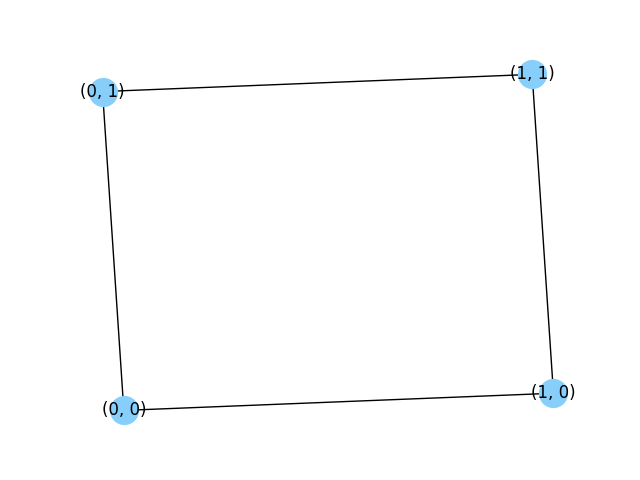

In [13]:
# plot traffic network structure
%matplotlib notebook
plt.figure()
gs = mpl.gridspec.GridSpec(1,1)
plot_graph(G, plt.subplot(gs[:]))

<IPython.core.display.Javascript object>


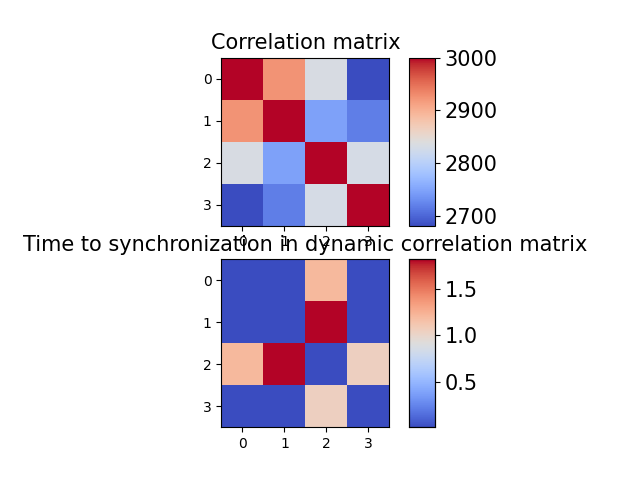

In [14]:
# plot the correlation matrix (phase correlation) and time to sync
plt.figure()
gs = mpl.gridspec.GridSpec(2, 1)
D_average = time_to_sync_matrix(t, w, A, B, Phi)
sum_rho_avg = sum_correlation_matrices(t, w, A, B, Phi)
plot_sum_corr_mat(sum_rho_avg, plt.subplot(gs[0, :]))
plot_time_to_sync(D_average, plt.subplot(gs[1, :]))
plt.box('off')

<IPython.core.display.Javascript object>


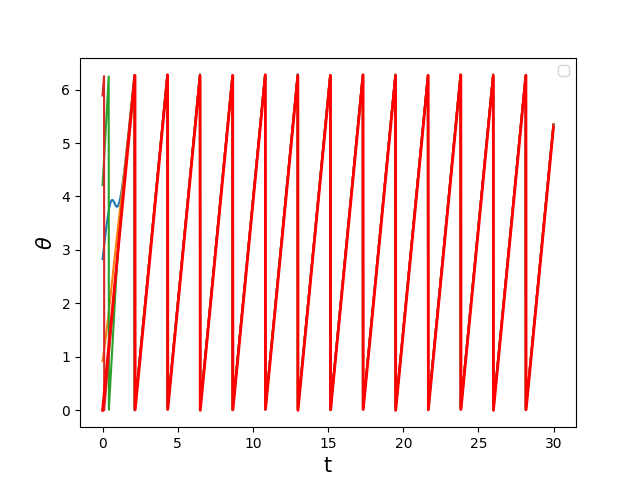

In [15]:
# plot oscillators evolution timeseries
plt.figure()
gs = mpl.gridspec.GridSpec(1,1)
plot_time_evolution(sol, t, Omega, plt.subplot(gs[:]))
plt.box('off')
plt.legend('')

<IPython.core.display.Javascript object>


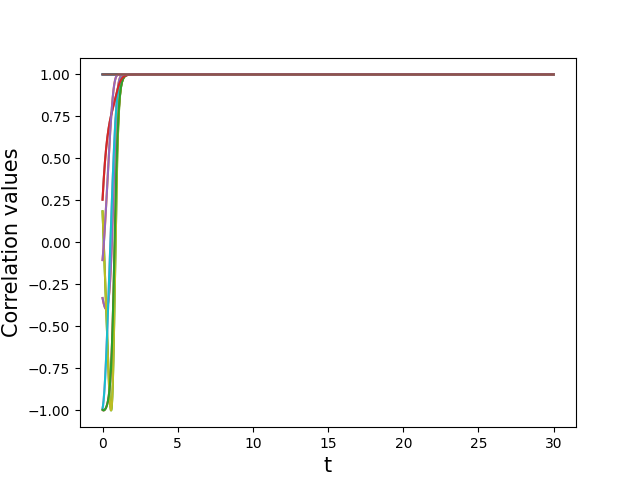

In [16]:
# correlation evolution in time
plt.figure()
gs = mpl.gridspec.GridSpec(1,1)
plot_corr_vals(corr_vals, t, plt.subplot(gs[:]))
plt.box('off')

<IPython.core.display.Javascript object>


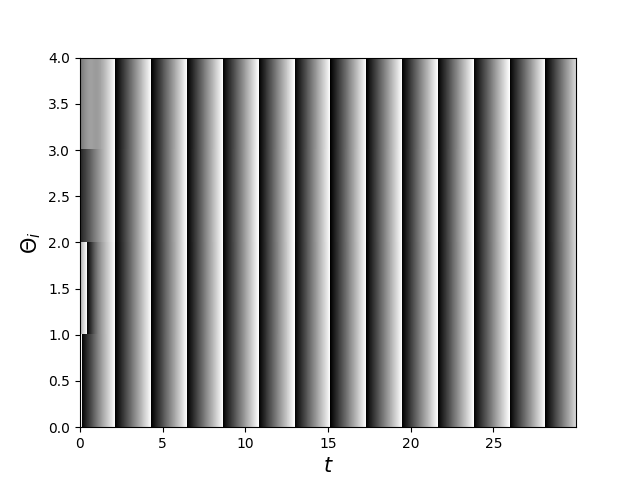

In [17]:
# plot heatmap of phases (demonstrates sync/coupling)
plt.figure()
gs = mpl.gridspec.GridSpec(1,1)
plot_heatmap_evolutions(sol, t, plt.subplot(gs[:]))

# Implementing the coupled oscillator system in neurons

## Theory

#### Basics
The **controlled oscillator** is an oscillator with an **extra input** that **controls the frequency** of the oscillation.

To implement a basic oscillator, we would use a **neural network** that has the following **dynamics**:

\begin{split}\dot{x} = \begin{bmatrix} 0 && - \omega \\ \omega && 0 \end{bmatrix} x\end{split}

where the frequency of oscillation is $\omega \over {2 \pi}$ Hz.

We need the **neurons to represent three variables**, $x_0$, $x_1$, and $ω$.

#### Convert dynamics equation into a feedback function

$$
\begin{split}\begin{align}
  \dot{x} &= f(x) &\implies f_{feedback}(x) = x + \tau f(x)
\end{align}\end{split}
$$

where $τ$ is the time constant of the feedback connection.

In this case, the feedback function to be computed is

$$
\begin{split}\begin{align}
  f_{feedback}(x) &= x + \tau
  \begin{bmatrix}
    0 && - \omega \\
    \omega && 0
  \end{bmatrix}
  x \\
  &=
  \begin{bmatrix}
    x_0 - \tau \cdot \omega \cdot x_1 \\
    x_1 + \tau \cdot \omega \cdot x_0
  \end{bmatrix}
\end{align}\end{split}
$$

# Create the neural network

In [34]:
import matplotlib.pyplot as plt
import nengo
from nengo.processes import Piecewise
%matplotlib inline

# Spiking Neural Net
tau = 0.1  # time constant for feedback
w_max = 10  # max frequency is w_max/(2*pi)

model = nengo.Network(label='Controlled Oscillator')
with model:
    # network implementing the the oscillator
    oscillator = nengo.Ensemble(500, dimensions=3, radius=1.7)

    # feedback connection of the oscillator
    def feedback(x):
        x0, x1, w = x  # These are the three variables stored in the ensemble
        return x0 + w * w_max * tau * x1, x1 - w * w_max * tau * x0, 0
    
    # connect network to itself
    nengo.Connection(oscillator, oscillator, function=feedback, synapse=tau)

    # network for controlling the speed of oscillation (external signal / drive)
    frequency = nengo.Ensemble(100, dimensions=1)
    
    # connect the external drive to the w parameter represented in the network
    nengo.Connection(frequency, oscillator[2])

# Prepare the input data

In [35]:
with model:
    # initial input to start the oscillator (i.e. initial condition)
    initial = nengo.Node(Piecewise({0: [1, 0, 0], 0.15: [0, 0, 0]}))
    
    # connect initial condition to the network 
    nengo.Connection(initial, oscillator)

    # swype w over time - this is the external driving signal
    input_frequency = nengo.Node(
        Piecewise({
            0: 1,
            1: 0.5,
            2: 0,
            3: -0.5,
            4: -1
        }))
    
    # connect the swyper to the actual frequency (external drive / reference to attain)
    nengo.Connection(input_frequency, frequency)

In [36]:
# add probe to monitor the oscillator
with model:
    # oscillator during simulation
    oscillator_probe = nengo.Probe(oscillator, synapse=0.03)

In [37]:
# add probe to monitor the external input
with model:
    # input during the simulation
    input_probe = nengo.Probe(frequency, synapse=0.03)

# Run the network

In [38]:
with nengo.Simulator(model) as sim:
    sim.run(5)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

# Analyse the output

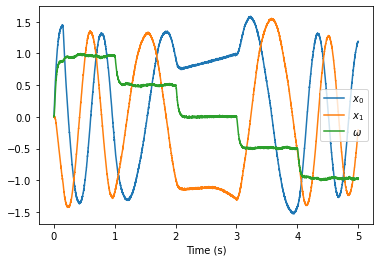

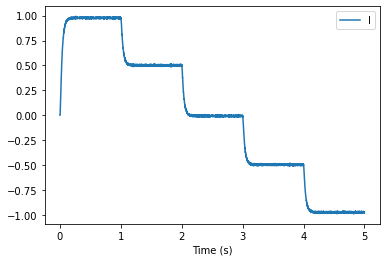

In [39]:
# plot behavior and input
plt.figure()
plt.plot(sim.trange(), sim.data[oscillator_probe])
plt.xlabel('Time (s)')
plt.legend(['$x_0$', '$x_1$', r'$\omega$'])
plt.box('off')
plt.figure()
plt.plot(sim.trange(), sim.data[input_probe])
plt.xlabel('Time (s)')
plt.legend('I')
plt.box('off')

# Experiments with multiple oscillators - Ring setup

In [40]:
import matplotlib.pyplot as plt
import nengo
import numpy as np
from nengo.processes import Piecewise
%matplotlib inline

# Spiking Neural Net
N = 300 # neurons
tau = 0.1  # time constant for feedback
w_max = 10  # max frequency is w_max/(2*pi)
n_osc = 8 # 8 oscillators for each of the 2 directions (right, straight) in a single cross

# define the model
model = nengo.Network(label='Controlled Coupled Oscillators Traffic Control - Single Cross')

with model:
    
    # feedback connection each of the oscillator
    def feedback(x):
        x0, x1, w = x  # These are the three variables stored in the ensemble
        return x0 + w * w_max * tau * x1, x1 - w * w_max * tau * x0, 0
      
    def coupling(x):
        x0, x1, w = x  # These are the three variables stored in the ensemble
        return x0 + w * w_max * tau * x1, x1 - w * w_max * tau * x0, 0    
    
    # initialize the network
    oscillators = [nengo.Ensemble]*n_osc
    
    # networks implementing each of the oscillators
    for i in range(n_osc):
        oscillators[i] = nengo.Ensemble(N, dimensions=3, radius=1.5)
    
    # connect oscillators to themselves
    for i in range(n_osc):
        nengo.Connection(oscillators[i], oscillators[i], function=feedback, synapse=tau)
        
    # network for controlling the speed of oscillation (external signal / drive)
    frequency = nengo.Ensemble(N, dimensions=1)
    
    # connect the external drive to the w parameter represented in the network in a cascade among oscillators
    for i in range(n_osc):
        nengo.Connection(frequency, oscillators[i][2], function=lambda x: x)
    
    # connect the oscillators in a ring, the w is fed externally and separately to all the oscillator (can be different)
    for i in range(n_osc-1):
        nengo.Connection(oscillators[i], oscillators[i+1], function=coupling, synapse=tau)
        
    # and close the ring for the current cross
    nengo.Connection(oscillators[n_osc-1], oscillators[0], function=coupling, synapse=tau)

# Experiments with multiple oscillators - Mesh setup

In [47]:
import matplotlib.pyplot as plt
import nengo
import numpy as np
from nengo.processes import Piecewise
%matplotlib inline

# Spiking Neural Net
N = 300 # neurons
tau = 0.1  # time constant for feedback
w_max = 10  # max frequency is w_max/(2*pi)
n_osc = 2 # oscillators per intersection, each coupling NS and WE
n_int = 4 # intersections to build a mesh of n_int x n_int

# define the model
model = nengo.Network(label='Controlled Coupled Oscillators Traffic Control - Multiple Crosses')

with model:
    
    # feedback connection each of the oscillator
    def feedback(x):
        x0, x1, w = x  # These are the three variables stored in the ensemble
        return x0 + w * w_max * tau * x1, x1 - w * w_max * tau * x0, 0
      
    def lateral_coupling(x):
        x0, x1, w = x  # These are the three variables stored in the ensemble
        return x0 + w * w_max * tau * x1, x1 - w * w_max * tau * x0, 0    
    
    def ring_coupling(x):
        x0, x1, w = x  # These are the three variables stored in the ensemble
        return x0 + w * w_max * tau * x1, x1 - w * w_max * tau * x0, 0    
    
    # initialize the network
    oscillators = [ [nengo.Ensemble for i in range(n_osc*n_int)]  for j in range(n_osc*n_int)] 
    
    # networks implementing each of the oscillators
    for i in range(0, n_osc*n_int):
        for j in range(0, n_osc*n_int):
            oscillators[i][j] = nengo.Ensemble(N, dimensions=3, radius=1.5)
    
    # connect oscillators to themselves
    for i in range(0, n_osc*n_int):
        for j in range(0, n_osc*n_int):
            if i==j:
                nengo.Connection(oscillators[i][j], oscillators[i][j], function=feedback, synapse=tau)
        
    # network for controlling the speed of oscillation (external signal / drive)
    frequency = nengo.Ensemble(N, dimensions=1)
    
    # connect the external drive to the w parameter represented in the network in a cascade among oscillators
    for i in range(0, n_osc*n_int):
        for j in range(0, n_osc*n_int):
            nengo.Connection(frequency, oscillators[i][j][2], function=lambda x: x)
    
    # connect the oscillators with lateral coupling (between intersection)
    for i in range(0, n_int*n_osc):
        for j in range(0, n_int*n_osc):
            nengo.Connection(oscillators[i][j], oscillators[j][i], function=lateral_coupling, synapse=tau)
            
    # connect the oscillators with ring coupling (within intersection)
    for i in range(0, n_int*n_osc, 2):
        for j in range(0, n_int*n_osc):
            nengo.Connection(oscillators[i][j], oscillators[i+1][j], function=ring_coupling, synapse=tau)

# Prepare the input data / driving signal

In [42]:
with model:
    # initial input to start the oscillator (i.e. initial condition)
    initial = nengo.Node(Piecewise({0: [1, 0, 0], 0.15: [0, 0, 0]}))
    
    # connect initial condition to the network by coupling with first oscillator
    for i in range(0, n_osc*n_int):
        for j in range(0, n_osc*n_int):
            nengo.Connection(initial, oscillators[i][j])

    # swype w over time - this is the external driving signal
    input_frequency = nengo.Node(
        Piecewise({
            0: 1,
            1: 0.5,
            2: 0,
            3: -0.5,
            4: -1
        }))
    
    # connect the swyper to the actual frequency (external drive / reference to attain)
    nengo.Connection(input_frequency, frequency)

In [43]:
# add probe to monitor the oscillator
with model:
    # oscillator during simulation
    oscillator_probes = [ [nengo.Probe for i in range(n_osc*n_int)]  for j in range(n_osc*n_int)] 
    for i in range(0, n_osc*n_int):
        for j in range(0, n_osc*n_int):
            oscillator_probes[i][j] = nengo.Probe(oscillators[i][j], synapse=0.03)

In [44]:
# add probe to monitor the external input
with model:
    input_probes = [ [nengo.Probe for i in range(n_osc*n_int)]  for j in range(n_osc*n_int)] 
    # input during the simulation
    for i in range(0, n_osc*n_int):
        for j in range(0, n_osc*n_int):        
            input_probes[i][j] = nengo.Probe(oscillators[i][j][2], synapse=0.03) # consistent with lambda on w input

# Run the network

In [45]:
with nengo.Simulator(model) as sim:
    sim.run(5)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

# Analyse the output

<ipython-input-49-b2ba72225e44>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


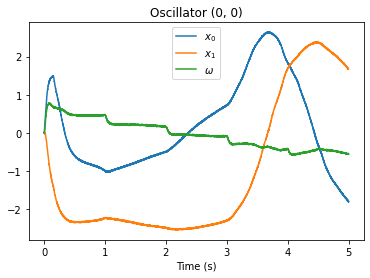

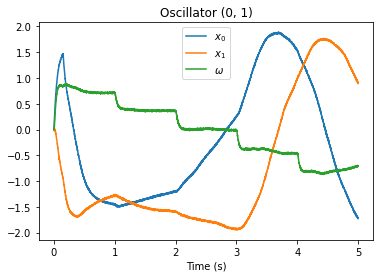

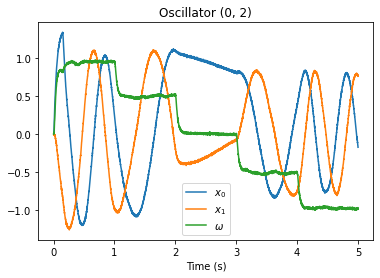

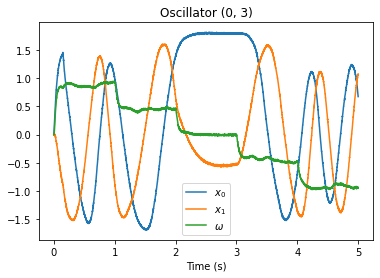

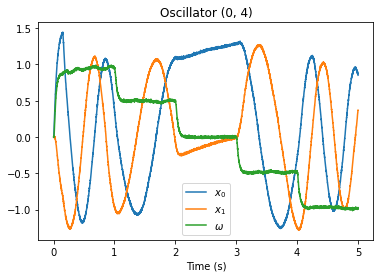

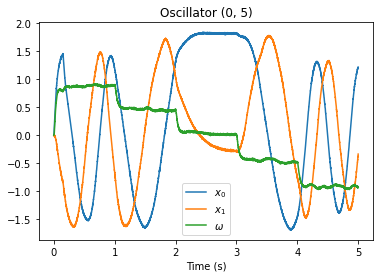

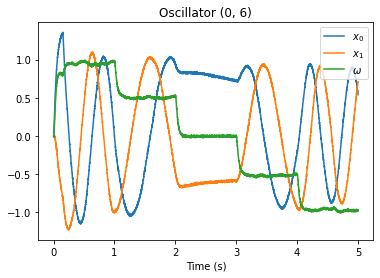

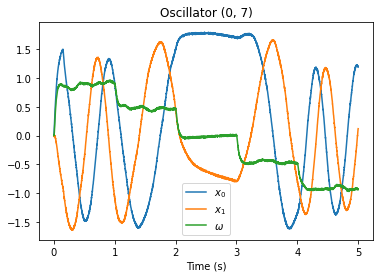

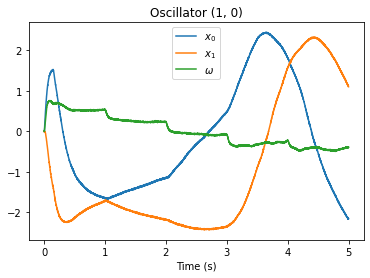

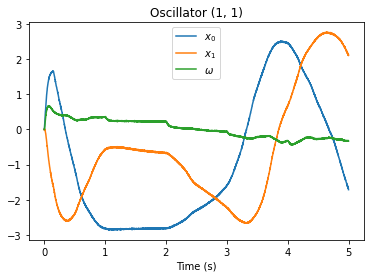

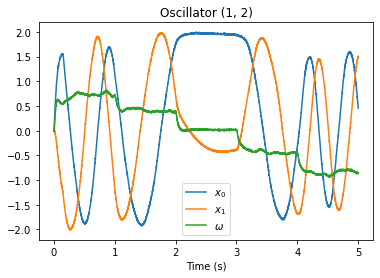

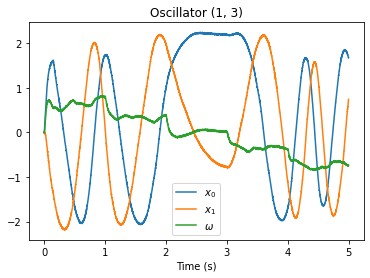

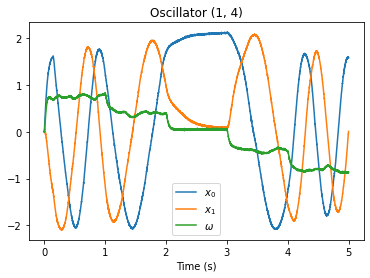

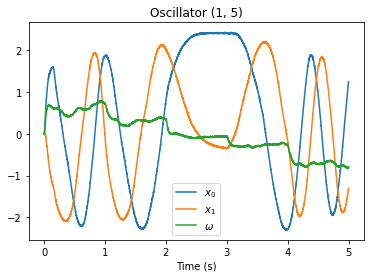

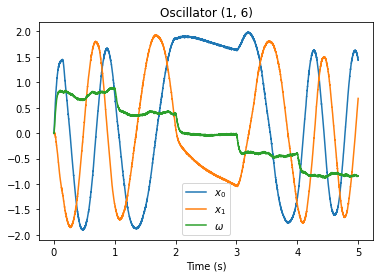

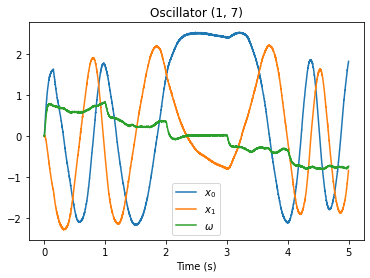

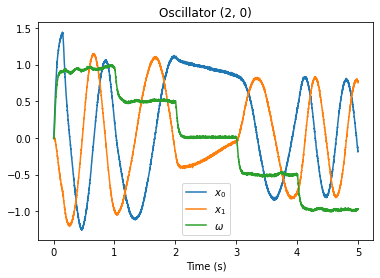

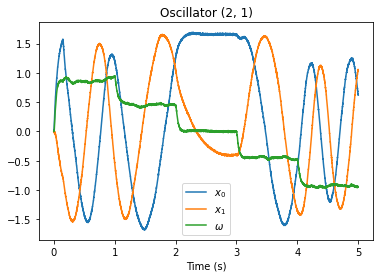

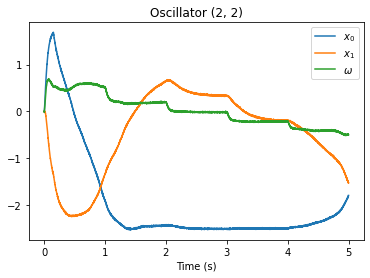

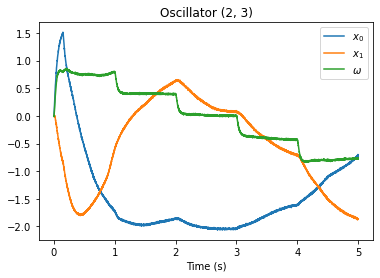

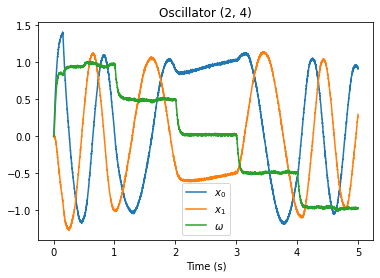

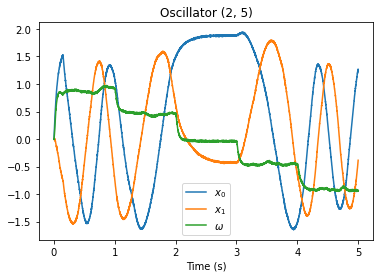

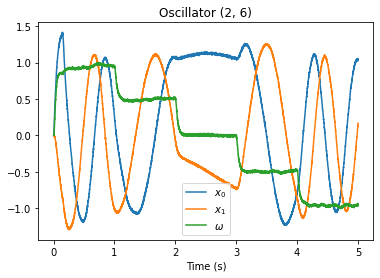

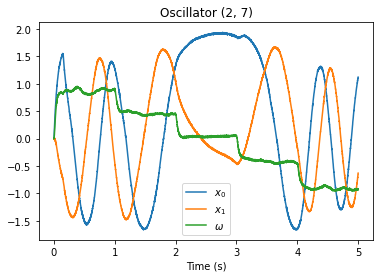

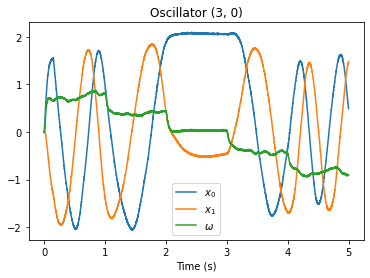

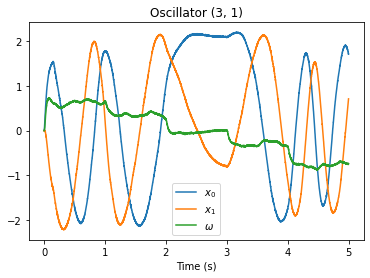

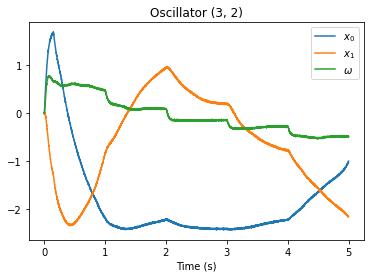

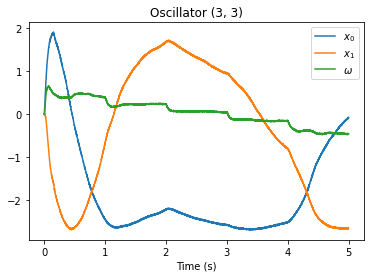

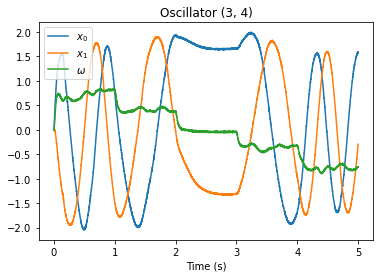

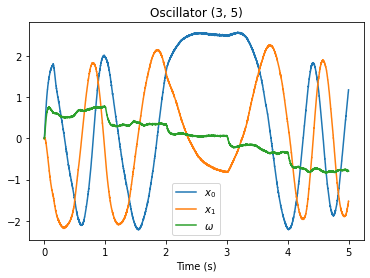

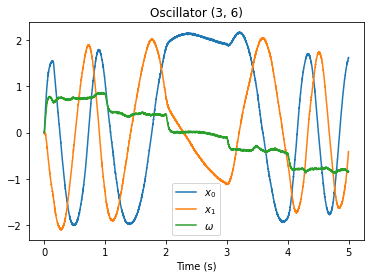

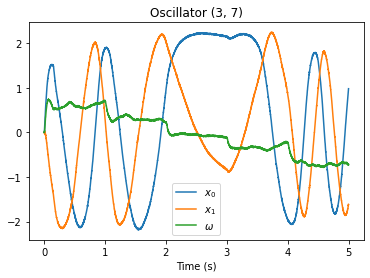

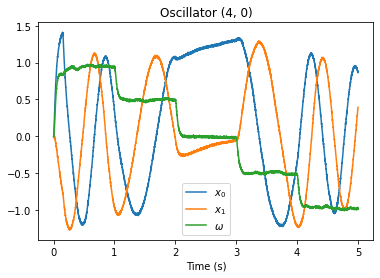

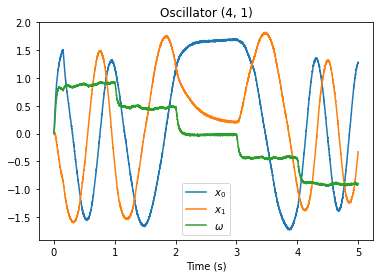

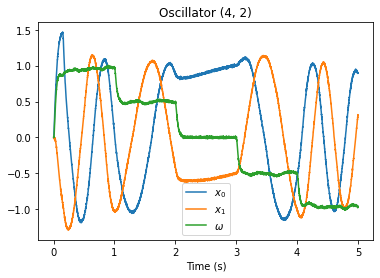

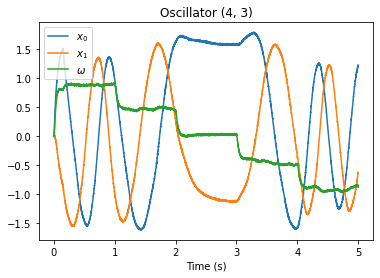

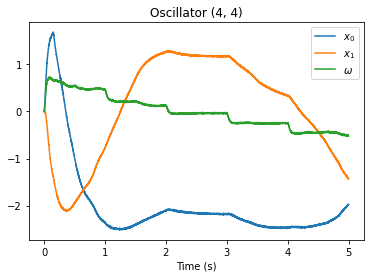

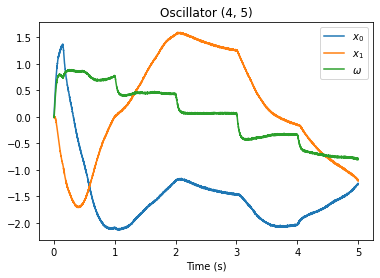

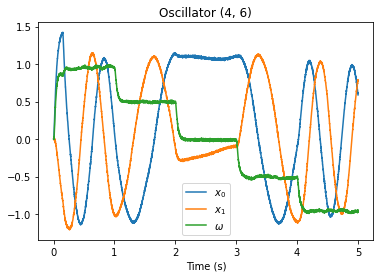

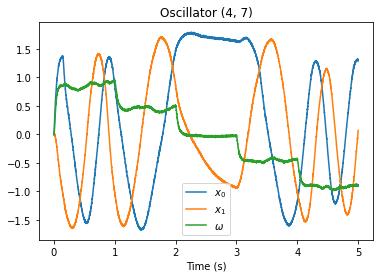

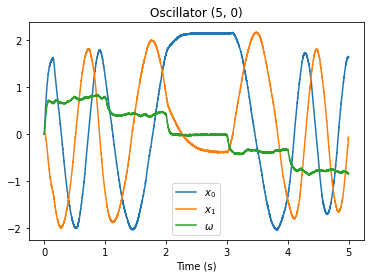

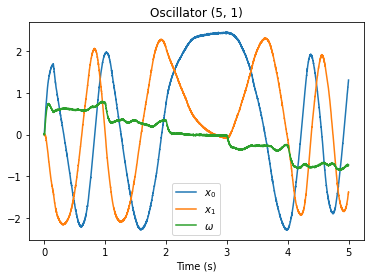

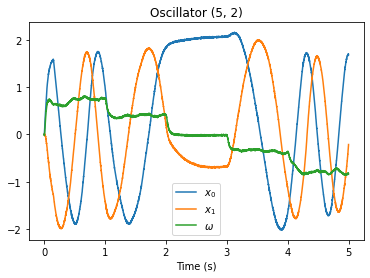

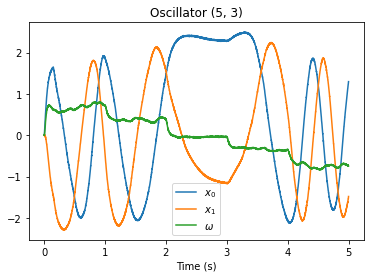

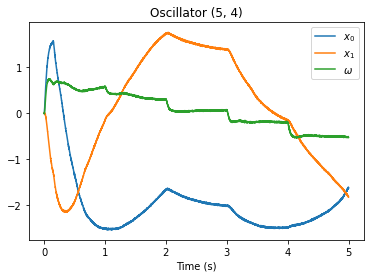

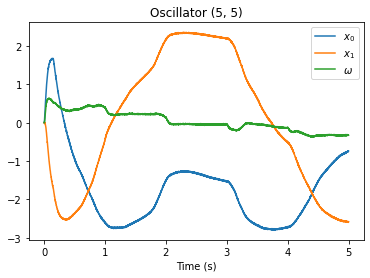

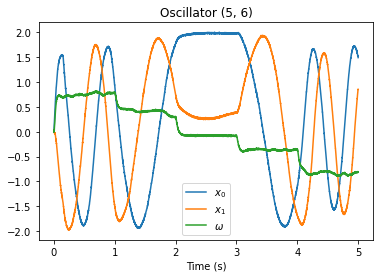

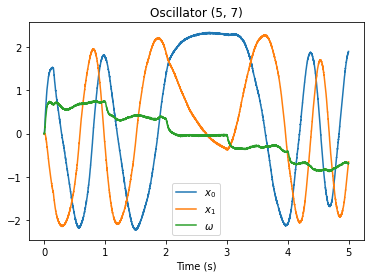

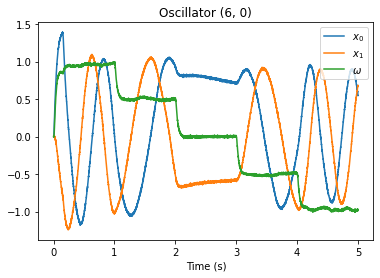

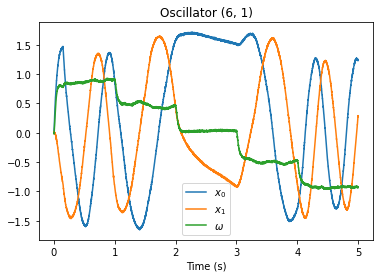

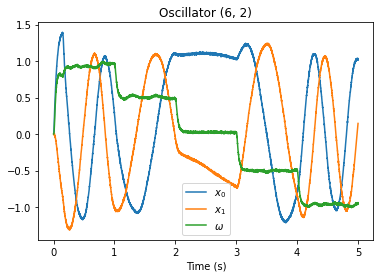

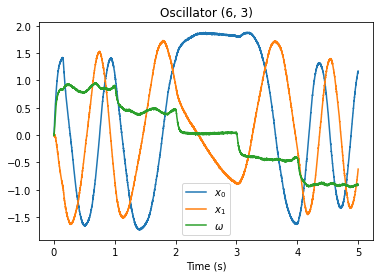

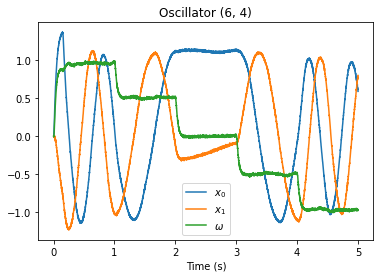

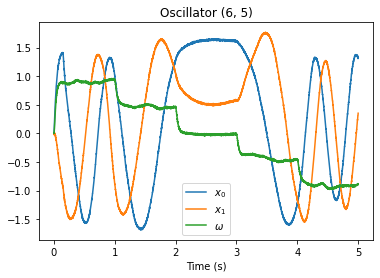

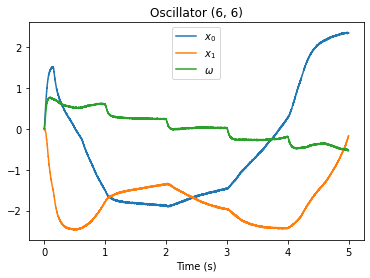

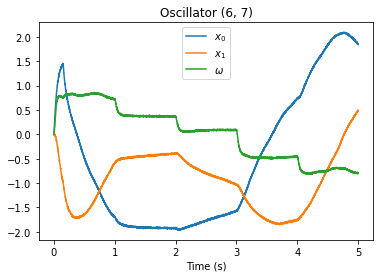

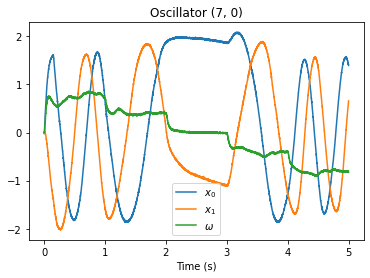

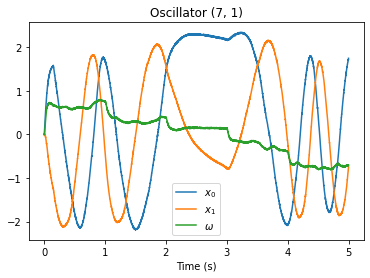

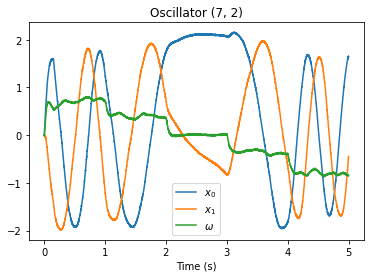

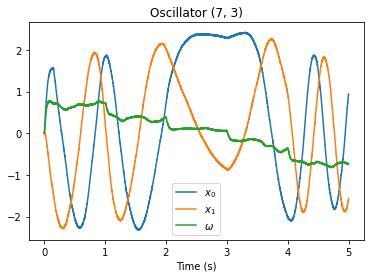

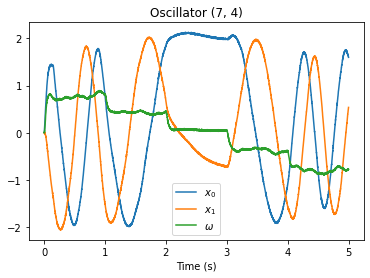

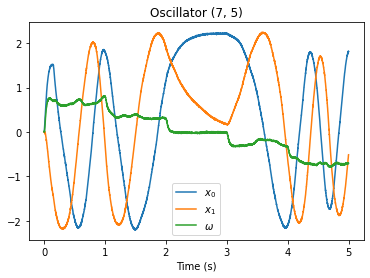

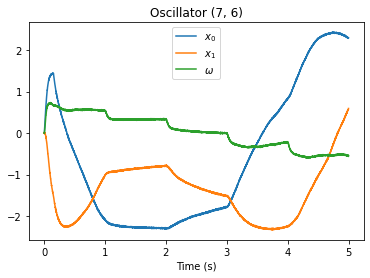

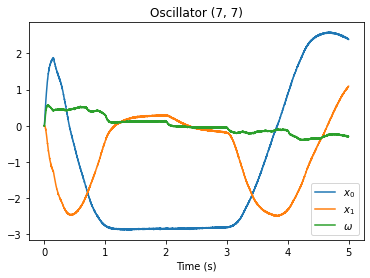

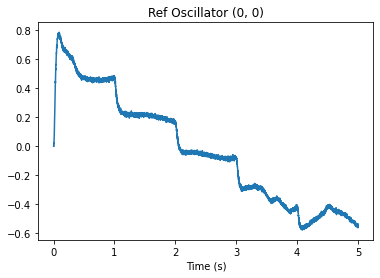

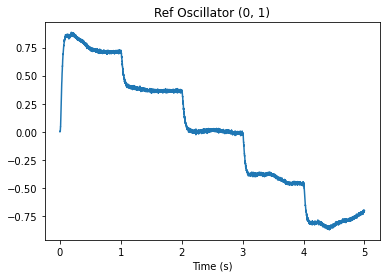

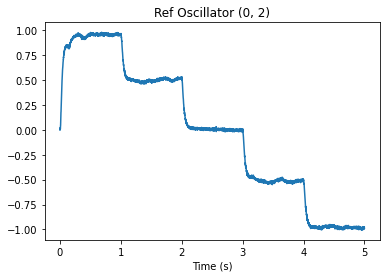

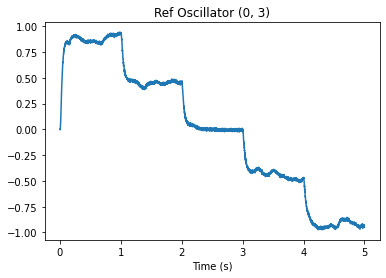

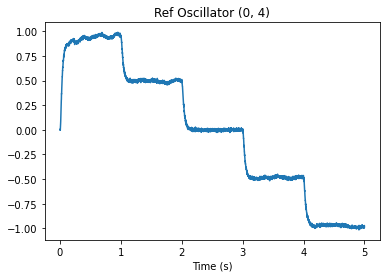

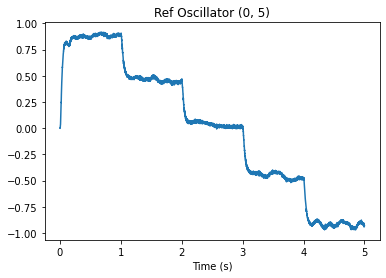

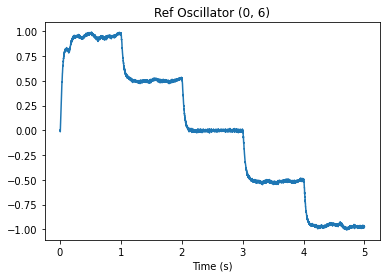

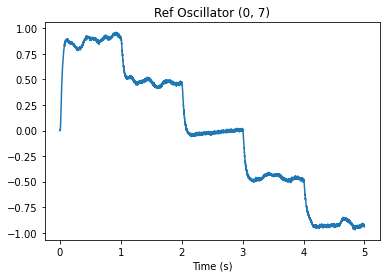

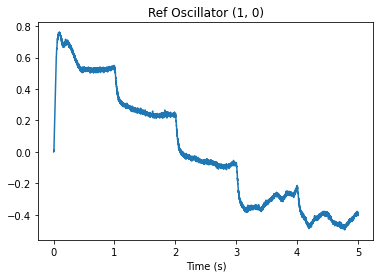

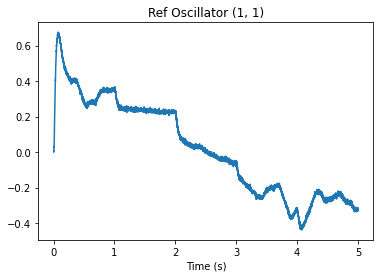

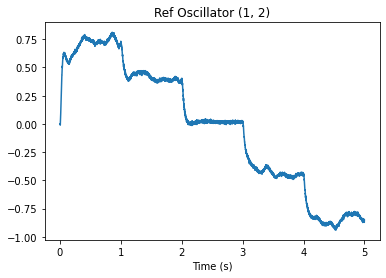

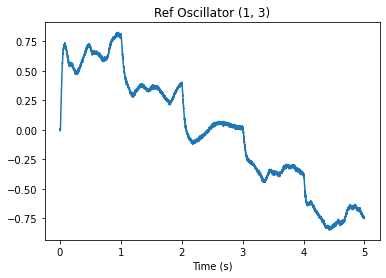

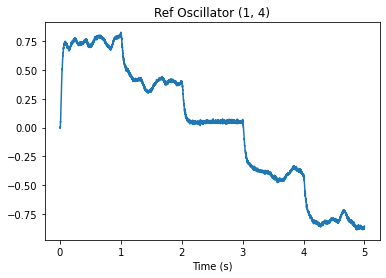

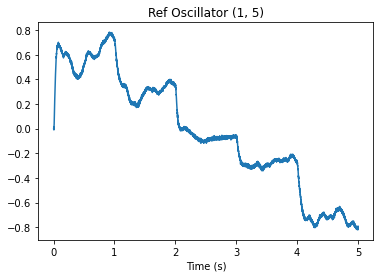

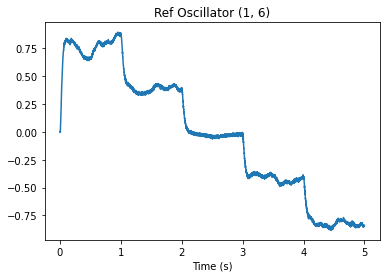

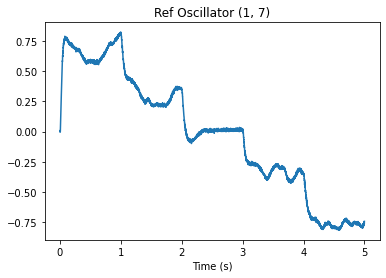

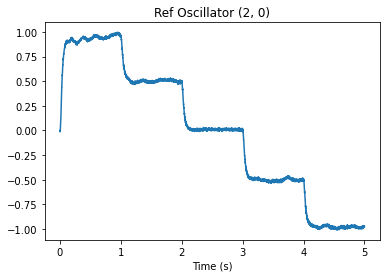

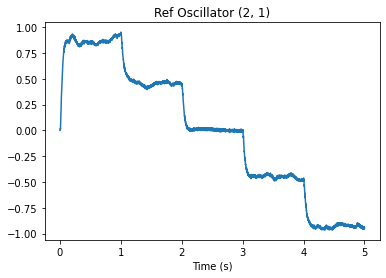

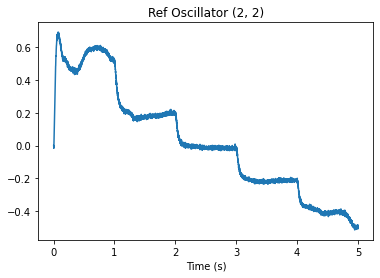

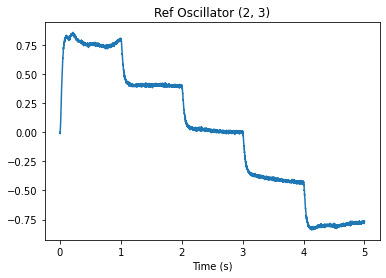

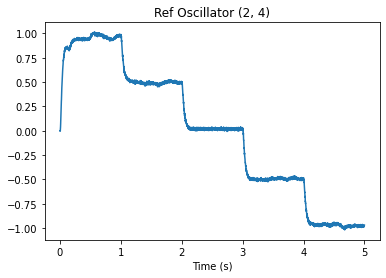

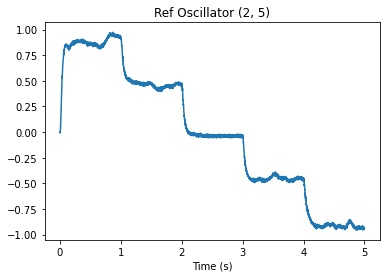

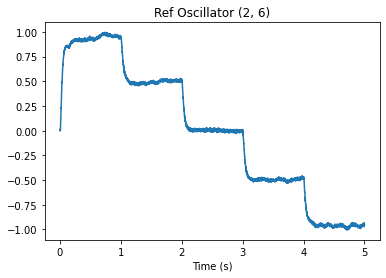

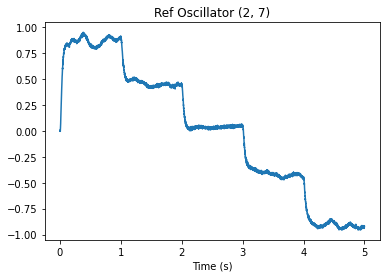

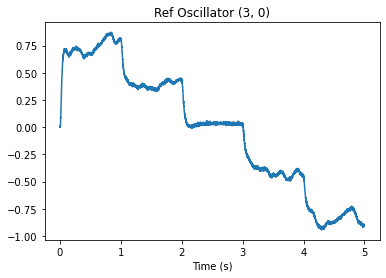

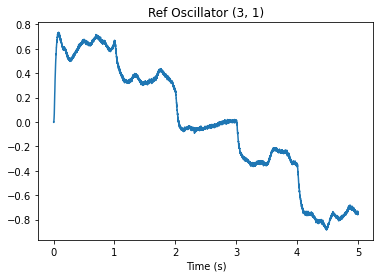

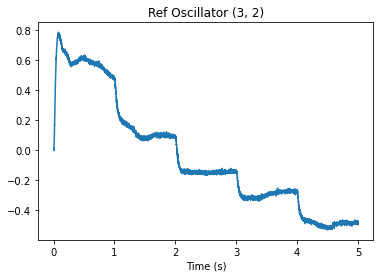

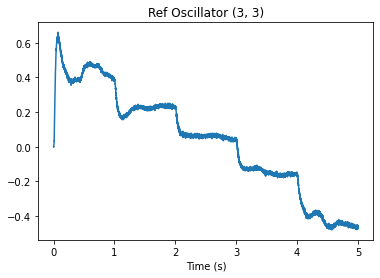

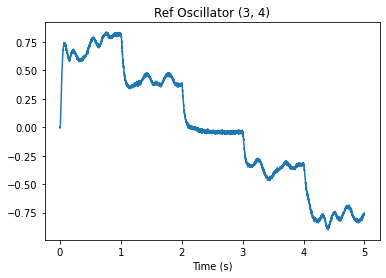

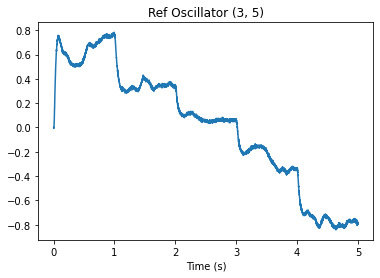

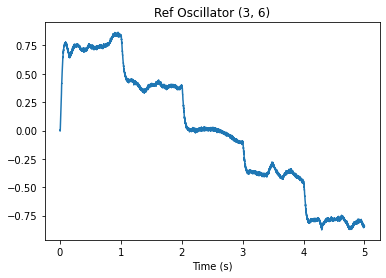

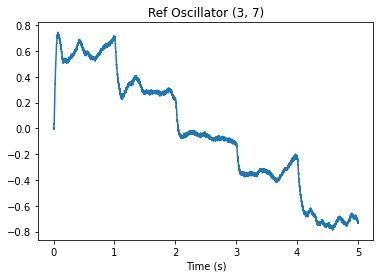

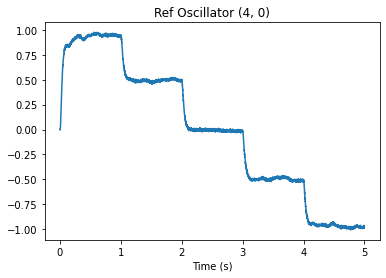

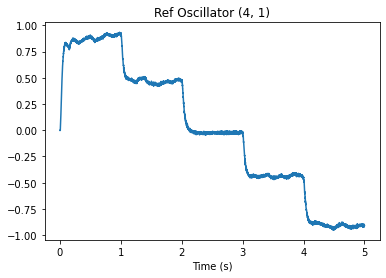

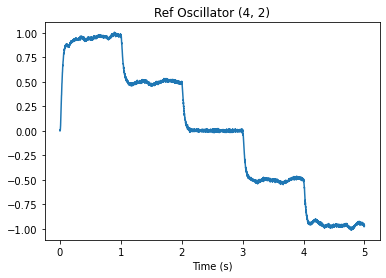

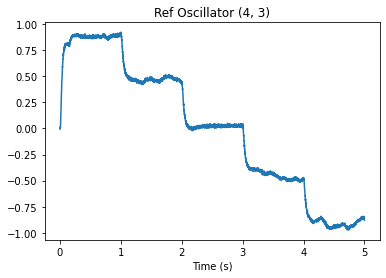

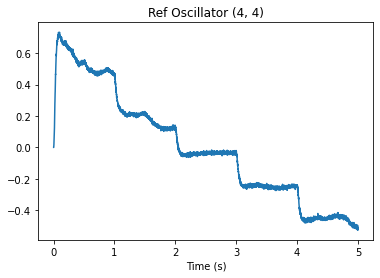

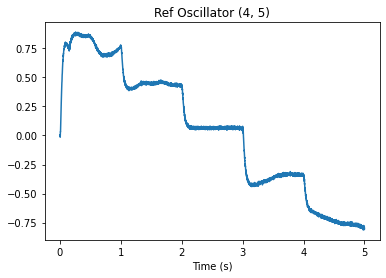

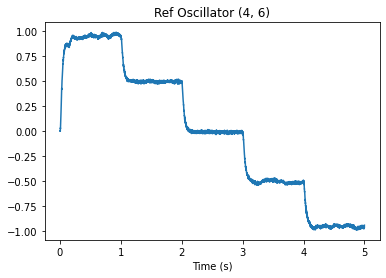

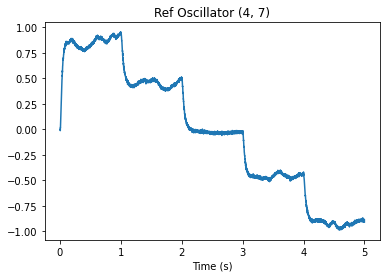

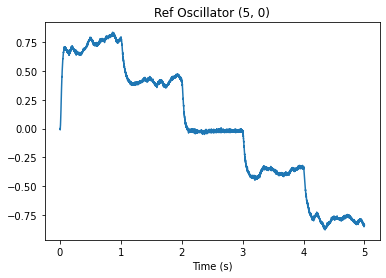

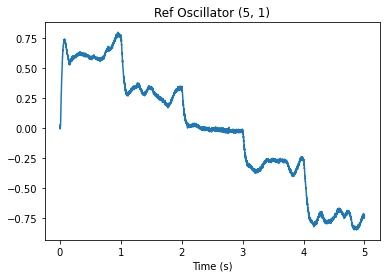

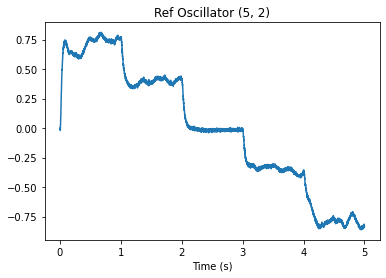

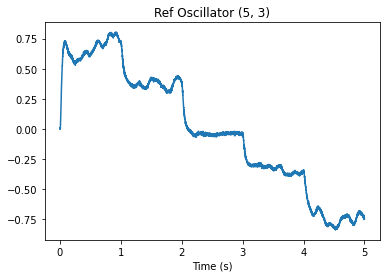

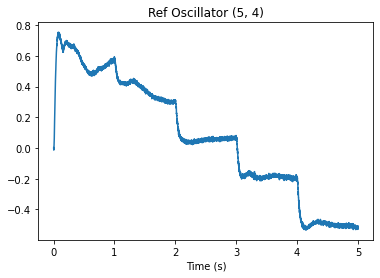

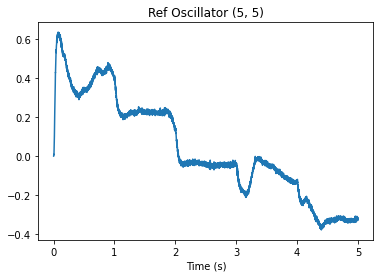

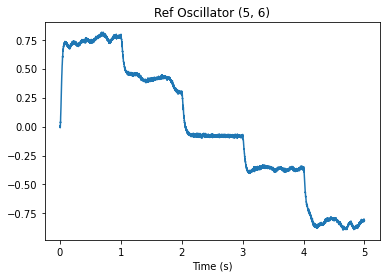

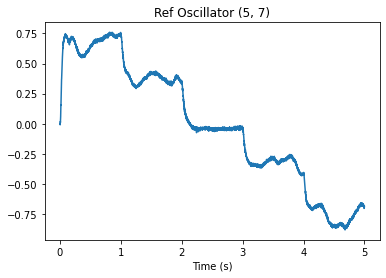

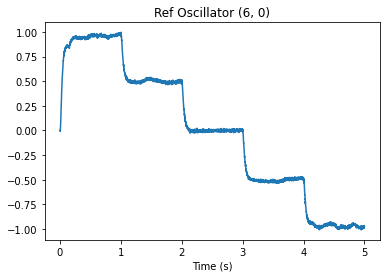

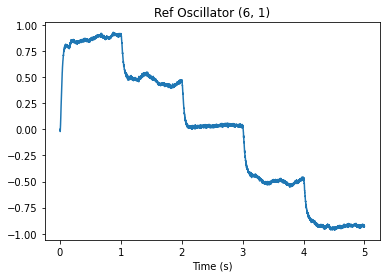

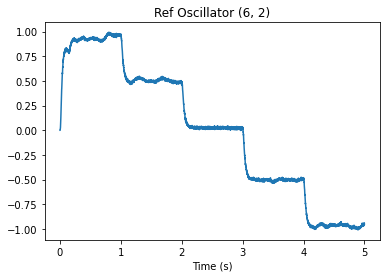

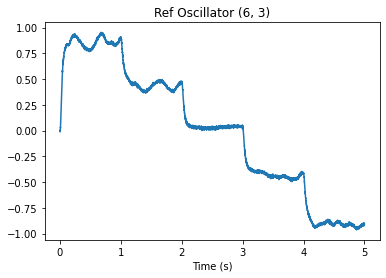

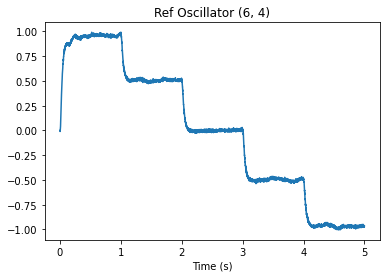

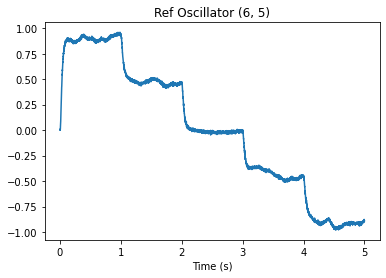

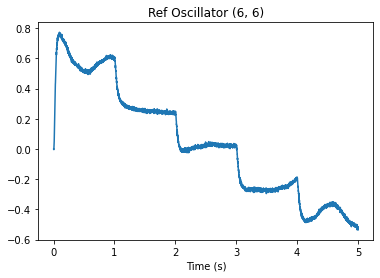

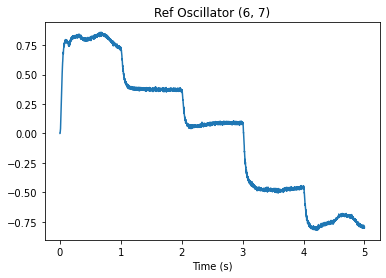

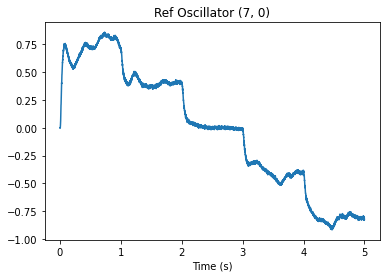

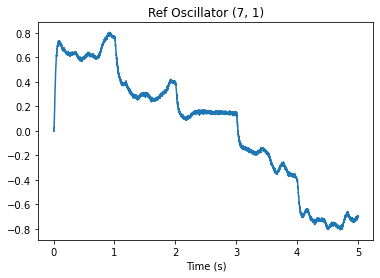

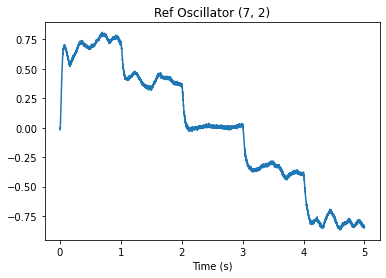

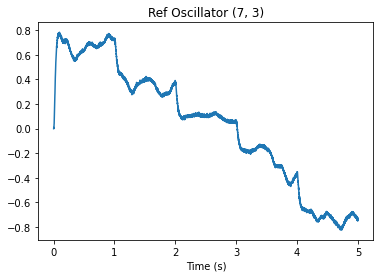

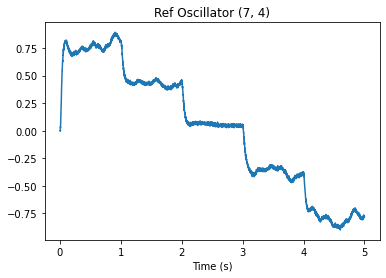

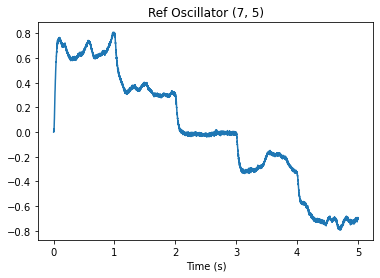

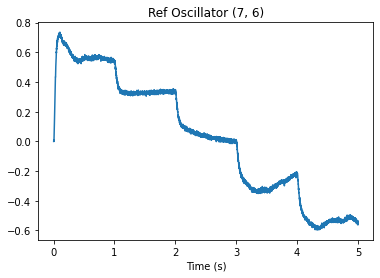

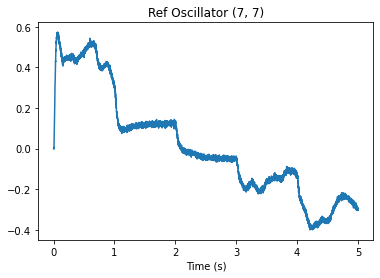

In [49]:
# plot behavior and input
for i in range(0, n_osc*n_int):
    for j in range(0, n_osc*n_int):
            plt.figure()
            plt.plot(sim.trange(), sim.data[oscillator_probes[i][j]])
            plt.xlabel('Time (s)')
            plt.legend(['$x_0$', '$x_1$', r'$\omega$'])
            plt.title("Oscillator (%d, %d)" % (i , j))
            plt.box('off')
for i in range(0, n_osc*n_int):
    for j in range(0, n_osc*n_int):
            plt.figure()
            plt.plot(sim.trange(), sim.data[input_probes[i][j]])
            plt.xlabel('Time (s)')
            plt.title("Ref Oscillator (%d, %d)" % (i , j))
            plt.box('off')